### Name: Sohan Rudra
### Roll No: 16MA20054

In [99]:
#library imports
import math
from collections import namedtuple
from fractions import Fraction 
from copy import copy
import numpy as np
from numpy.linalg import inv
from sympy import symbols
import matplotlib.pyplot as plt

In [64]:
#some boilerplate code
x = symbols('x')
#Equation = namedtuple('Equation',('a','b'))
Conditions = namedtuple('Conditions',('n','f0','F0','Fn','h','e'))

In [65]:
%%latex
\begin{align}
f''' - ff' + 1 - f' = 0\\
f_0 = 0\\
f'_0 = 0\\
f_n = 1\\
n = 10\\
\end{align}

<IPython.core.display.Latex object>

In [74]:
def initializer(cond):
    Vals = np.zeros((2, cond.n + 1))
    Vals[1][-1] = cond.Fn
    return Vals

In [95]:
def Finite_Diff_Solver(cond, f_k, verbose=True):
    n = cond.n
    a, b, c, d = np.zeros((n-2, 2, 2)), np.zeros((n-1, 2, 2)),\
    np.zeros((n-2, 2, 2)), np.zeros((n-1, 2))
    #A
    b[0] = np.array([[1.0, -cond.h/2.0], [(f_k[1][2] - f_k[1][0])/(2.0*cond.h),\
                                          (-2.0/cond.h**2 - 2.0*f_k[1][1])]])
    c[0] = np.array([[0.0, 0.0], [0.0, (1.0/cond.h**2 + f_k[0][1]/(2.0*cond.h))]])
    b[n-2] = np.array([[1.0, -cond.h/2.0], [(f_k[1][-1] - f_k[1][-3])/(2.0*cond.h),\
                                            (-2.0/cond.h**2 - 2.0*f_k[1][-2])]])
    a[n-3] = np.array([[-1.0, -cond.h/2.0], [0.0, (1.0/cond.h**2 -\
                                                   f_k[0][-2]/(2.0*cond.h))]])
    #d
    d[0] = np.array([f_k[0][0] -f_k[0][1] + cond.h/2.0 *(f_k[1][1] + f_k[1][0]),\
                     -1.0 + f_k[1][1]**2 - f_k[0][1]/(2.0*cond.h)*(f_k[1][2] -\
                    f_k[1][0]) - (f_k[1][2] - 2.0 * f_k[1][1] + f_k[1][0])/cond.h**2])
    d[n-2] = np.array([f_k[0][-3] - f_k[0][-2] + cond.h/2.0 *(f_k[1][-2] + f_k[1][-3]),\
                       -1.0 + f_k[1][-2]**2 - f_k[0][-2]/(2.0*cond.h)*(f_k[1][-1] -\
                    f_k[1][-2]) - (f_k[1][-3] - 2.0 * f_k[1][-2] + f_k[1][-1])/cond.h**2])
    for i, xi in enumerate(np.arange(1, cond.n-2), start=1):
        #print(i)
        a[i-1] = np.array([[-1.0, -cond.h/2.0], [0.0, (1.0/cond.h**2 -\
                                                f_k[0][i+1]/(2.0*cond.h))]])
        b[i] = np.array([[1.0, -cond.h/2.0], [(f_k[1][i+2] - f_k[1][i])/(2.0*cond.h),\
                                              (-2.0/cond.h**2 - 2.0*f_k[1][i+1])]])
        c[i] = np.array([[0.0, 0.0], [0.0, (1.0/cond.h**2 + f_k[0][i+1]/(2.0*cond.h))]])
        d[i] = np.array([f_k[0][i] - f_k[0][i+1] + cond.h/2.0 *(f_k[1][i+1] + f_k[1][i]),\
                         -1.0 + f_k[1][i+1]**2 - f_k[0][i+1]/(2.0*cond.h)*(f_k[1][i+2] -\
                    f_k[1][i+1]) - (f_k[1][i] - 2.0 * f_k[1][i+1] + f_k[1][i+2])/cond.h**2])
        
    if verbose:
        print("A={}, B={}, C={}, D={}".format(a,b,c,d))
        
    return (a,b,c,d)

In [82]:
def Thomas_Algorithm(coeff, cond, f_k):
    a, b, c, d = coeff
    n = cond.n
    c1 = np.zeros((n-2, 2, 2))
    d1 = np.zeros((n-1, 2))
    c1[0] = inv(b[0]).dot(c[0])
    d1[0] = inv(b[0]).dot(d[0])
    #print(d1.shape)
    for i in range(1,n-2):
        t1 = b[i]-a[i-1].dot(c1[i-1])
        c1[i] = inv(t1).dot(c[i])
        d1[i] = inv(t1).dot(d[i] - a[i-1].dot(d1[i-1]))
    d1[n-2] = inv(b[n-2] - a[n-3].dot(c1[n - 3])).dot(d[n-2] - a[n-3].dot(d1[n-3]))
    def backsubstitution(c,d):
        y = np.zeros_like(d)
        y[-1] = d[-1]
        cache = y[-1]
        #print(cache.shape)
        for i in reversed(range(d.shape[0]-1)):
            y[i] = d[i] - c[i].dot(cache)
            cache = y[i]
        return y
    fin_y = backsubstitution(c1,d1)
    #print(fin_y.shape)
    dfn = cond.h/2.0 * (f_k[1][-1] + f_k[1][-2] + fin_y.T[1][-1]) +\
    fin_y.T[0][-1] + f_k[0][-2] - f_k[0][-1]
    dFn = 0.0
    #print( np.array([dfn, dFn]))
    y = np.concatenate((fin_y, np.array([[dfn, dFn]])))
    y = np.concatenate((np.array([[0.0, 0.0]]), y))
    #print(y)
    return y.T

In [96]:
def Newton_Solver(cond):
    print(cond.n)
    print(initializer(cond))
    y_k = initializer(cond)
    tuples_coeff = Finite_Diff_Solver(cond, y_k, verbose=False)
    dy = Thomas_Algorithm(tuples_coeff, cond, y_k)
    y = y_k + dy
    s = np.max(abs(y[0] - y_k[0]))
    y_k = y
    solutions = []
    while(s > cond.e):
        y_k = copy(y)
        solutions.append(y_k)
        tuples_coeff = Finite_Diff_Solver(cond, y_k, verbose=False)
        dy = Thomas_Algorithm(tuples_coeff, cond, y_k)
        y = y_k + dy
        s = np.max(abs(y[0] - y_k[0]))
        #print(s)
        
    y_k = y
    solutions.append(y_k)
    return solutions

In [97]:
cond = Conditions(10,0.0,0.0,1.0,1.0,0.001)

In [98]:
y = Newton_Solver(cond)

10
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


In [72]:
y[0]

array([ 0.        ,  0.34049175,  1.03377497,  1.5819385 ,  1.64821834,
        0.95632134, -0.37228436, -1.32645828, -1.26369076, -0.5822934 ,
        0.34796344])

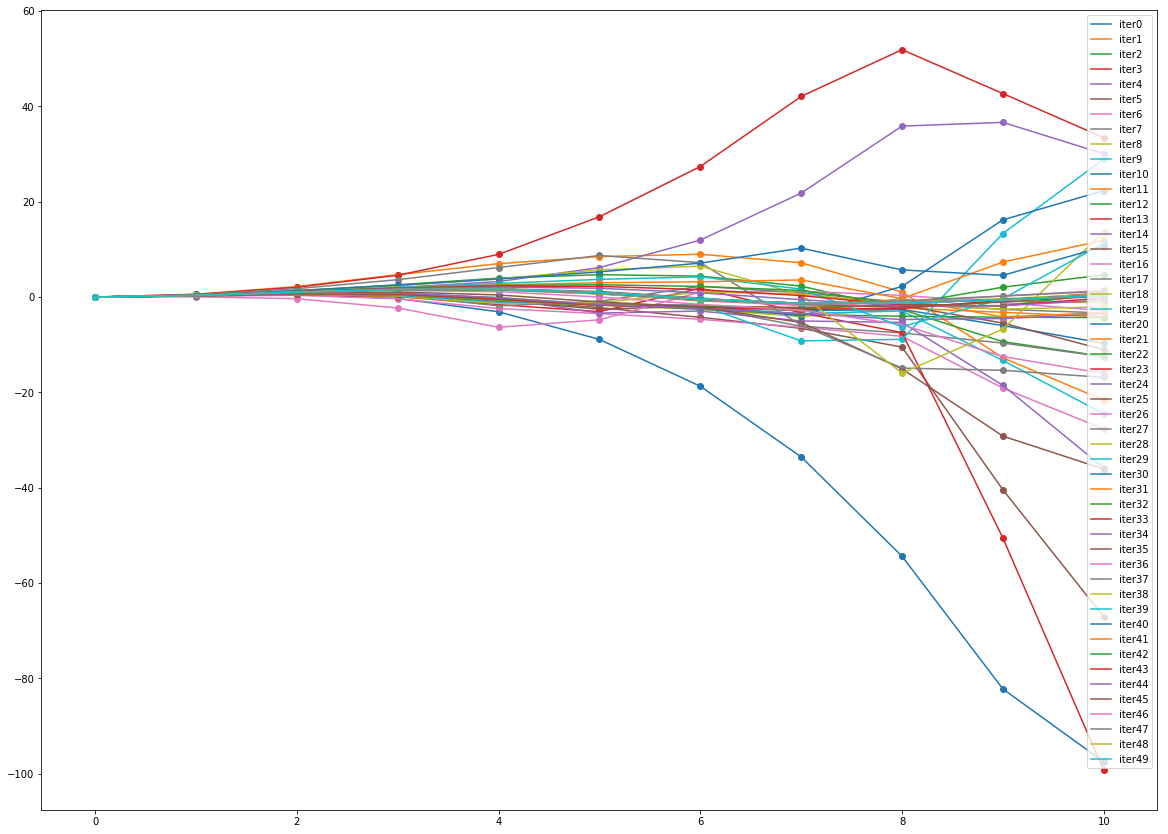

In [87]:
#t1 = np.arange(cond.x0, cond.xn, 0.001)
x_range = np.arange(0, cond.n + 1)
fig = plt.figure(figsize=(20, 50))
ax = fig.add_subplot(311)
g = []
for i in range(len(y)):
    ax.plot(x_range, y[i][0])
    ax.scatter(x_range, y[i][0])
    g.append("iter"+str(i))
ax.legend(tuple(g))
fig.show()

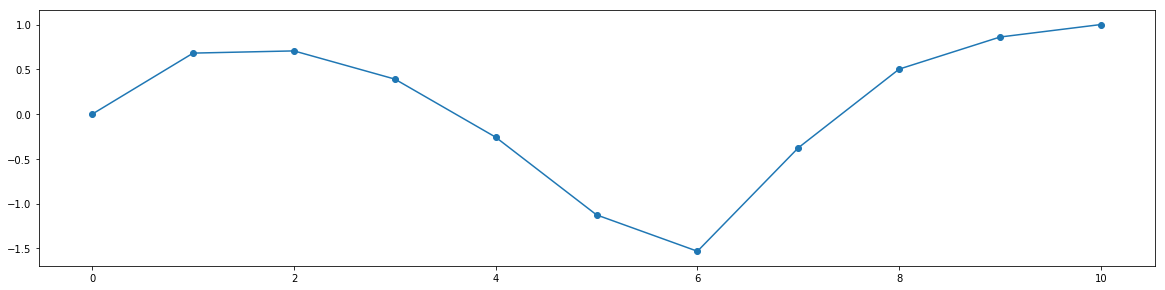

In [90]:
fig = plt.figure(figsize=(20,16))
x_range = np.arange(0, cond.n + 1)
ax = fig.add_subplot(311)
ax.plot(x_range, y[i][-1])
ax.scatter(x_range, y[i][-1])
fig.show()